Plot the exported highres pickle files of NenuFAR

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

machine = 'nancep' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/data/mnedal'
    folder_path = '/data/mnedal/outputs/data'
    outputs     = '/data/mnedal/outputs/plots'

In [2]:
# mydate = '2025-03-25'
# year, month, day = mydate.split('-')
mydate = '20250326'

In [3]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
for f in enumerate(nenufar_files):
    print(f)

(0, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesI_typeIII_G1.pkl')
(1, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1.pkl')
(2, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1_fullres.pkl')
(3, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesI_typeIII_G2.pkl')
(4, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesV_over_I_typeIII_G2.pkl')
(5, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl')
(6, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesV_over_I_typeIII_G3.pkl')
(7, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_104500_20250325_104900_stokesI_typeIII_G4.pkl')
(8, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_1045

In [23]:
SRB_groupname = 'typeII' # typeIII_G1, typeIII_G2, typeIII_G3, typeIII_G4, typeII

g_files = [f for f in nenufar_files if mydate in f and f.endswith(f'{SRB_groupname}.pkl')] # find the filenames that end with G1
print(*g_files, sep='\n')

stokesI_filename  = [f for f in g_files if 'stokesI' in f][0]
stokesVI_filename = [f for f in g_files if 'stokesV_over_I' in f][0]

df_int = pd.read_pickle(stokesI_filename)
df_pol = pd.read_pickle(stokesVI_filename)

# Convert arb. unit to dB for Stokes I
df_int = 10 * np.log10(df_int) # Convert the amplitude to decibels

/data/mnedal/outputs/data/nenufar/combined_dyspec_20250326_091312_20250326_095609_stokesI_typeII.pkl
/data/mnedal/outputs/data/nenufar/combined_dyspec_20250326_091312_20250326_095609_stokesV_over_I_typeII.pkl


<b>Original cadence:</b>
* Frequency resolution: 6.10 kHz
* Time resolution: 20.97 ms

In [6]:
print('Stokes I:')
print(f'Frequency resolution: {np.median(np.diff(df_int.columns)*1e3):.2f} kHz')
print(f'Time resolution: {np.median(np.diff(df_int.index)/np.timedelta64(1,"ms")):.2f} ms')
print(f'Data shape: {df_int.shape}\n')

print('Stokes V/I:')
print(f'Frequency resolution: {np.median(np.diff(df_pol.columns)*1e3):.2f} kHz')
print(f'Time resolution: {np.median(np.diff(df_pol.index)/np.timedelta64(1,"ms")):.2f} ms')
print(f'Data shape: {df_pol.shape}')

Stokes I:
Frequency resolution: 97.66 kHz
Time resolution: 20.97 ms
Data shape: (122882, 640)

Stokes V/I:
Frequency resolution: 97.66 kHz
Time resolution: 20.97 ms
Data shape: (122882, 640)


## Plot the highres dynamic spectra

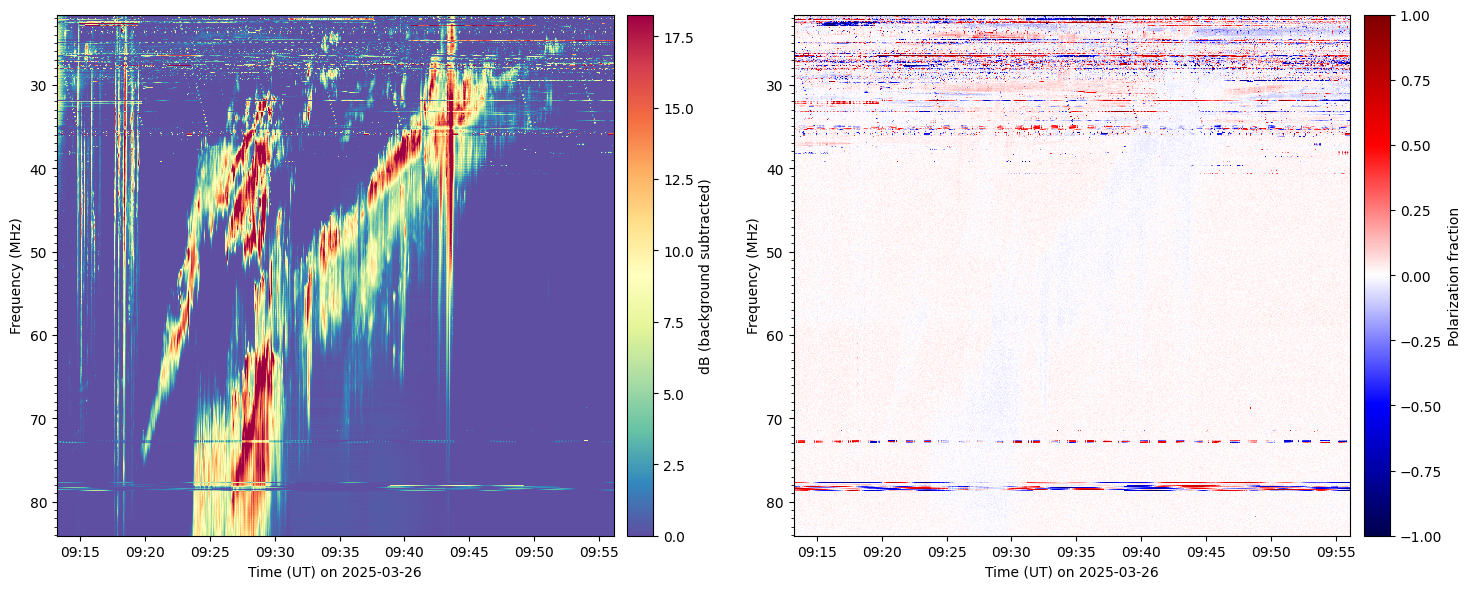

In [25]:
dyspec_subtracted = df_int_1s - np.tile(np.nanmedian(df_int_1s,0), (df_int_1s.shape[0],1))

fig = plt.figure(figsize=[15,6])

ax = fig.add_subplot(121)
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T,
                   vmin=0, vmax=np.percentile(dyspec_subtracted, 99),
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB (background subtracted)')
ax.set_xlabel(f'Time (UT) on {df_int.index[0].date()}')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlim(left=pd.Timestamp(f'{df_int.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_int.index[0].date()} 09:41:00'))

ax = fig.add_subplot(122)
pc = ax.pcolormesh(df_pol.index, df_pol.columns, df_pol.T,
                   vmin=-1, vmax=1,
                   cmap='seismic')
fig.colorbar(pc, ax=ax, pad=0.02, label='Polarization fraction')
ax.set_xlabel(f'Time (UT) on {df_pol.index[0].date()}')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlim(left=pd.Timestamp(f'{df_pol.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_pol.index[0].date()} 09:41:00'))
fig.tight_layout()
plt.show()

## Plot lightcurves

In [27]:
radio_lq_sI = {}
f_targets = [32, 35, 38, 40, 50, 60, 70, 80] # freq channels Conisdered

combined_data_sI  = df_int.values
combined_freqs_sI = df_int.columns

# Find index of closest value
for f_target in f_targets:
    f_index      = np.abs(combined_freqs_sI - f_target).argmin()
    freq_channel = f'{round(combined_freqs_sI[f_index])} MHz'
    radio_lq_sI[freq_channel] = combined_data_sI[:, f_index]

print(radio_lq_sI.keys())

dict_keys(['32 MHz', '35 MHz', '38 MHz', '40 MHz', '50 MHz', '60 MHz', '70 MHz', '80 MHz'])


In [29]:
radio_lq_sVI = {}
f_targets = [32, 35, 38, 40, 50, 60, 70, 80] # freq channels conisdered

combined_data_sVI = df_pol.values
combined_freq_sVI = df_pol.columns

# Find index of closest value
for f_target in f_targets:
    f_index      = np.abs(combined_freq_sVI - f_target).argmin()
    freq_channel = f'{round(combined_freq_sVI[f_index])} MHz'
    radio_lq_sVI[freq_channel] = combined_data_sVI[:, f_index]

print(radio_lq_sVI.keys())

dict_keys(['32 MHz', '35 MHz', '38 MHz', '40 MHz', '50 MHz', '60 MHz', '70 MHz', '80 MHz'])


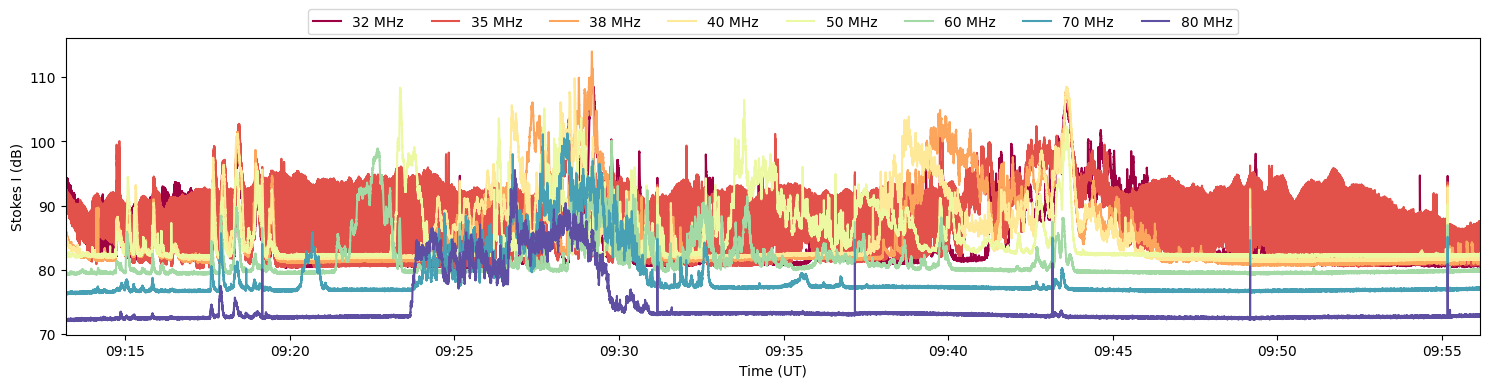

In [35]:
# Choose a colormap with many distinguishable colors
cmap        = plt.cm.get_cmap('Spectral')
num_lines   = len(radio_lq_sI.keys())
colors_list = cmap(np.linspace(0, 1, num_lines))

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lq_sI):
    ax.plot(df_int.index, radio_lq_sI[key], color=colors_list[i], label=key)

ax.legend(loc='best')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Stokes I (dB)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=df_int.index[0], right=df_int.index[-1])
# ax.set_xlim(left=pd.Timestamp(f'{df_int.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_int.index[0].date()} 09:41:00'))
# ax.set_ylim(ymin=-0.5, ymax=0.5)
fig.tight_layout()
plt.show()

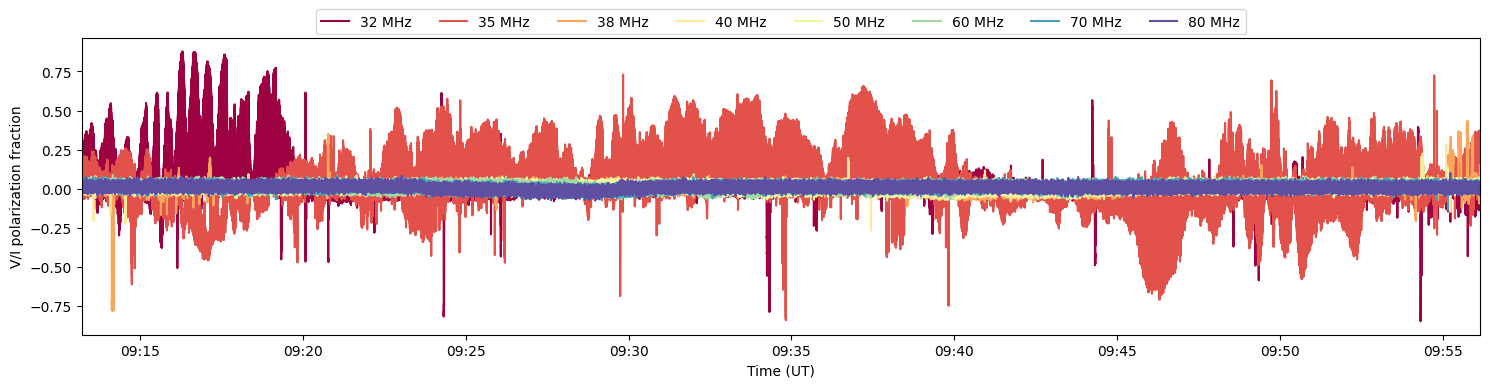

In [36]:
# Choose a colormap with many distinguishable colors
cmap        = plt.cm.get_cmap('Spectral')
num_lines   = len(radio_lq_sVI.keys())
colors_list = cmap(np.linspace(0, 1, num_lines))

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lq_sVI):
    ax.plot(df_pol.index, radio_lq_sVI[key], color=colors_list[i], label=key)

ax.legend(loc='best')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('V/I polarization fraction')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=df_pol.index[0], right=df_pol.index[-1])
# ax.set_xlim(left=pd.Timestamp(f'{df_pol.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_pol.index[0].date()} 09:41:00'))
# ax.set_ylim(ymin=-0.5, ymax=0.5)
fig.tight_layout()
plt.show()

## Smooth data using the Savitzky-Golay filter

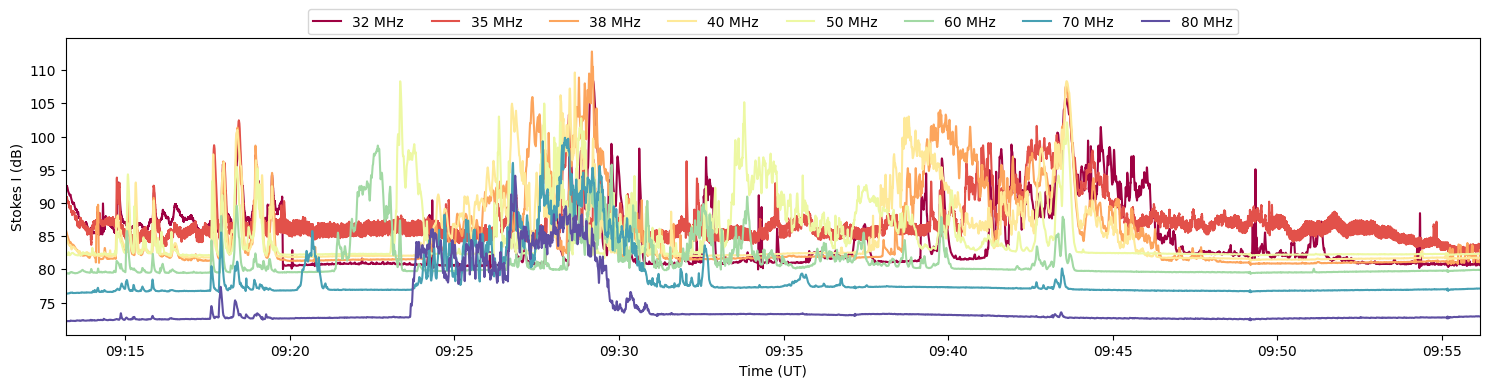

In [37]:
# Set smoothing parameters
window_size = 101  # must be odd and less than the number of data points
poly_order  = 3    # typical choice: 2 or 3
y_model = {}

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lq_sI):
    y = radio_lq_sI[key]
    
    # Apply Savitzky-Golay filter if long enough
    if len(y) >= window_size:
        y_smooth = savgol_filter(y, window_length=window_size, polyorder=poly_order)
    else:
        y_smooth = y  # Skip smoothing if too short

    y_model[key] = y_smooth
    ax.plot(df_int.index, y_smooth, color=colors_list[i], label=key)

# Formatting and labels
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Stokes I (dB)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=df_int.index[0], right=df_int.index[-1])
# ax.set_xlim(left=pd.Timestamp(f'{df_int.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_int.index[0].date()} 09:41:00'))
fig.tight_layout()
plt.show()

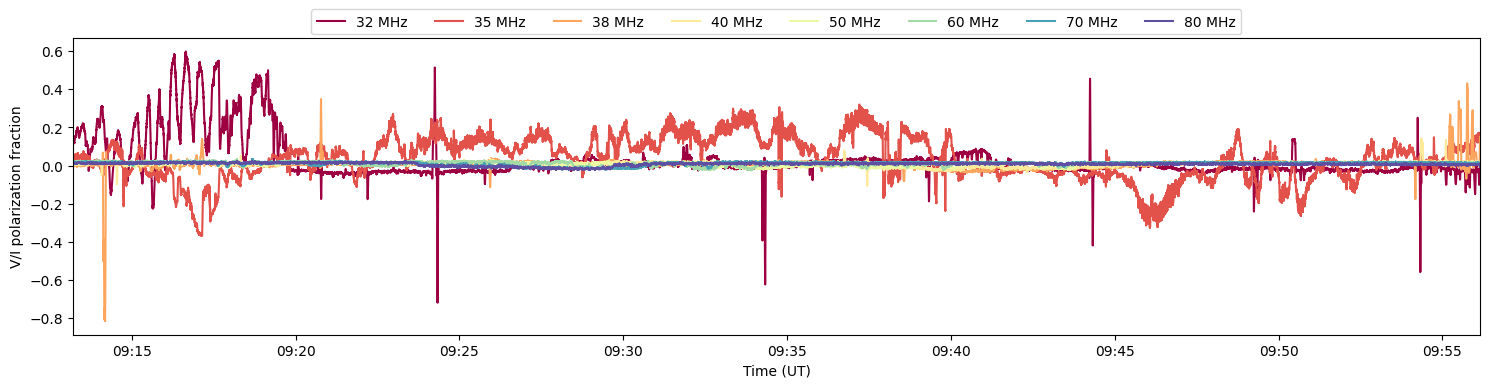

In [34]:
# Set smoothing parameters
window_size = 101  # must be odd and less than the number of data points
poly_order  = 3    # typical choice: 2 or 3
y_model = {}

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lq_sVI):
    y = radio_lq_sVI[key]
    
    # Apply Savitzky-Golay filter if long enough
    if len(y) >= window_size:
        y_smooth = savgol_filter(y, window_length=window_size, polyorder=poly_order)
    else:
        y_smooth = y  # Skip smoothing if too short

    y_model[key] = y_smooth
    ax.plot(df_pol.index, y_smooth, color=colors_list[i], label=key)

# Formatting and labels
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('V/I polarization fraction')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=df_pol.index[0], right=df_pol.index[-1])
# ax.set_xlim(left=pd.Timestamp(f'{df_pol.index[0].date()} 09:36:00'),
#             right=pd.Timestamp(f'{df_pol.index[0].date()} 09:41:00'))
fig.tight_layout()
plt.show()

<b>Important Notes</b>

The Savitzky-Golay filter is not a global fit — it’s a local smoother

That means:
* It doesn’t fit a single polynomial to your whole dataset.
* Instead, it fits a small polynomial to each local window of points to smooth the signal.
* So there’s no global model, hence no single residual array or $R^2$ value in the usual sense.
* The $R^2$ value here tells you how close the smoothed signal is to the original — not how well a "true model" fits the data.
* Since smoothing removes high-frequency noise, $R^2$ might be < 1 even for good smoothing, which is expected

You can treat the smoothed signal as a "model" and compare it to the original as follows

In [ ]:
# # Use the same time index from your data
# time_index = df_nenufar.index

# # Set up subplot layout
# num_panels = len(radio_lightcurves)
# fig, axes = plt.subplots(num_panels, 1, figsize=(15, 2.5 * num_panels))#, sharex=True)

# # If there's only one panel, put it in a list
# if num_panels == 1:
#     axes = [axes]

# # Define common time formatter
# time_formatter = mdates.DateFormatter('%H:%M')

# # Loop through each lightcurve
# for i, key in enumerate(radio_lightcurves):
#     ax = axes[i]
#     ax2 = ax.twinx()  # Second y-axis for residuals

#     # Get real and smoothed signals
#     y_real    = radio_lightcurves[key]
#     y_smooth  = y_model[key]
#     residuals = y_real - y_smooth

#     # Plot real and smoothed
#     ax.plot(time_index, y_real, label=f'Real ({key})', color='black', alpha=0.5)
#     ax.plot(time_index, y_smooth, label='Smoothed', color='tab:blue', zorder=100)

#     # Plot residuals on right y-axis
#     ax2.plot(time_index, residuals, label='Residual', color='tab:red', alpha=0.4)

#     # Axis formatting
#     ax.set_ylabel('V/I polarization fraction')
#     ax2.set_ylabel('Residual', color='tab:red')
#     ax2.tick_params(axis='y', labelcolor='tab:red')
#     ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
#     ax.yaxis.set_minor_locator(AutoMinorLocator(n=4))
#     ax2.yaxis.set_minor_locator(AutoMinorLocator(n=4))

#     # Set legend
#     lines, labels   = ax.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax.legend(lines + lines2, labels + labels2, loc='upper right')

#     # Format x-axis
#     ax.xaxis.set_major_formatter(time_formatter)
#     ax.set_xlim(pd.Timestamp(f'{time_index[0].date()} 09:36:00'),
#                 pd.Timestamp(f'{time_index[0].date()} 09:41:00'))

# axes[-1].set_xlabel('Time (UT)')
# fig.tight_layout()
# plt.show()

In [ ]:
# Prepare time index
time_index = df_pol.index

# Set up 2-column subplot layout: 4 rows × 2 columns
nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12), sharex=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Time formatter
time_formatter = mdates.DateFormatter('%H:%M')

# Loop over keys and axes
for i, (key, ax) in enumerate(zip(radio_lq_sVI, axes)):
    ax2 = ax.twinx()

    y_real    = radio_lq_sVI[key]
    y_smooth  = y_model[key]
    residuals = y_real - y_smooth

    # Plot real and smoothed signals
    ax.plot(time_index, y_real, label='Real', color='black', alpha=0.5)
    ax.plot(time_index, y_smooth, label='Smoothed', color='tab:blue', zorder=100)

    # Plot residuals on right y-axis
    ax2.plot(time_index, residuals, label='Residual', color='tab:red', alpha=0.4)

    ax.set_title(f'{key}')
    ax.set_ylabel('V/I Pol. fraction')
    ax2.set_ylabel('Residual', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='small')

    ax.xaxis.set_major_formatter(time_formatter)
    ax.set_xlim(left=time_index[0], right=time_index[-1])
    
    # ax.set_xlim(pd.Timestamp(f'{time_index[0].date()} 09:36:00'),
    #             pd.Timestamp(f'{time_index[0].date()} 09:41:00'))

    ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=4))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(n=4))

# Set x-axis label only on the bottom row
for ax in axes[-2:]:
    ax.set_xlabel('Time (UT)')

# Global y-axis label (optional)
# fig.text(0.06, 0.5, 'V/I Polarization Fraction', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.15)
plt.show()